In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed = 42

$\renewcommand{\vec}[1]{\mathbf{#1}}$
**Refresher**  

[online lectures](http://videolectures.net/course_information_theory_pattern_recognition/)

_Stirling's approximation_ $$x!\approx x^xe^{-x}$$
_Binomial distribution_ $$P(r\mid f,N)={N\choose r}f^r(1-f)^{N-r}$$
For approximating $N\choose r$ using Sterling's formula we introduce the _binary entropy function_
$$H_2(x)\equiv x\log_2\frac1x+(1-x)\log_2\frac1{1-x}$$
so now,
$${N\choose r}\approx 2^{NH_2(r/N)}$$

# 1 Introduction to information Theory

The first problem to consider is transmitting messages over noisy channels (telephone lines, radio communication, disk drives, reproducing cells).

_binary symmetric channel:_ we transmit several bits, each has a probability $f$ to be flipped.

For example, transmitting a picture of dilbert over a noisy channel with $f=0.1$

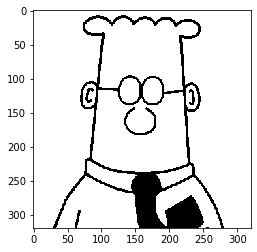

In [248]:
dilbert = plt.imread("res/dilbert.png")
# turn to black and white
thresh = 0.5
dilbert_bw = np.average(dilbert, axis=2)
dilbert_bw[dilbert_bw<=thresh] = 0
dilbert_bw[dilbert_bw>thresh] = 1
plt.imshow(dilbert_bw, cmap='gray')
ds = dilbert_bw.flatten() # flatten to 1d array as message

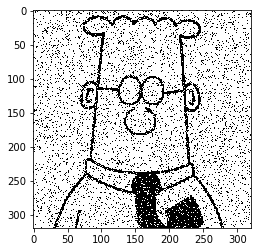

In [249]:
def transmit(msg, f=0.10):
    # for some reason f=0.1 actually gives 0.01 probability. I suspect
    # its something with decimal vs binary
    noise = np.random.binomial(1, f, msg.size)
    return np.float32(np.logical_xor(msg, noise))


plt.imshow(transmit(ds).reshape(dilbert_bw.shape), cmap='gray');

The information theory solution is using error correcting code, encode the message with redundancy so that the probability of an error is low.
We have an encoder and a decoder. The encoder encodes a message $\mathbf{s}$ into a transmitted message $\mathbf{t}$, the channel adds noise yielding a received message $\mathbf{r}$, and the decoder infers the original signal $\mathbf{\hat s}$.

First example, repetition codes. Simply repeat each bit $n$ times. The decoder will choose the majority vote for each bit, the optimal decoding method.

In [107]:
class RepCode:
    def __init__(self, n=3):
        self.n = n
        
    def encode(self, s):
        return np.repeat(s, self.n)
    
    def decode(self, r):
        maj = r.reshape(r.size//self.n, self.n).sum(axis=1)
        maj[maj < self.n/2.] = 0
        maj[maj > self.n/2.] = 1
        return maj
    
def error(s, r):
    return (s != r).sum() / r.size

rc3 error probability: 0.144921875
naive error probability: 0.469853515625


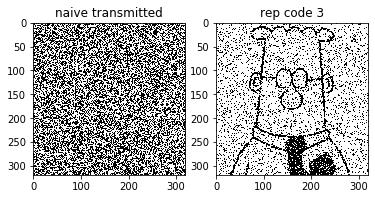

In [288]:
rc3 = RepCode(309)
f = 0.47
received = transmit(rc3.encode(ds), f=f)
s_hat = rc3.decode(received)
naive = transmit(ds, f=f)
print(f'rc3 error probability: {error(ds, s_hat)}')
print(f'naive error probability: {error(ds, naive)}')
f, ax = plt.subplots(1, 2)
ax[0].set_title("naive transmitted")
ax[1].set_title("rep code 3")
ax[0].imshow(naive.reshape(dilbert_bw.shape), cmap='gray')
ax[1].imshow(s_hat.reshape(dilbert_bw.shape), cmap='gray');

**Exercise 1.2** compute the error probablity of $\text{R}_3$ in a binary symmetric channel with noise level f.

The error probability is the probability that two bits are flipped, scales as $f^2$. In our case, $p_b\approx0.03$ per bit, but the rate has fallen by a third.

_Block codes; (7, 4) Hamming code_  
We take another approach, encoding blocks instead of bits. For each block of size N we add K _parity-check bits_ which will store the parity of a subset of the block. We can represent it linearly
$$\vec{t}=\vec{G}^T\vec{s}$$

$$\vec{G}^T=\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
1 & 1 & 1 & 0 \\
0 & 1 & 1 & 1 \\
1 & 0 & 1 & 1 \\
\end{bmatrix}$$
and we use modulo-2 arithmetic.

After we encode and transfer, we look at the difference between the parity-bits we can calculate from the first N bits and the actual received parity-bits. Each deviation entails a bit flip to restore validity. In the case that indeed one bit was flipped we will restore the original message. In case there are two or more, the message will be further corrupted.

If we write $$\vec{G}^T = 
\begin{bmatrix}
\vec{I}_4 \\
\vec{P}
\end{bmatrix} $$

Then $$\vec{H} = \begin{bmatrix} \vec{P} & \vec{I}_3 \end{bmatrix}$$
satisfies for $$\vec{Ht}=\begin{bmatrix} 0\\0\\0\end{bmatrix}$$
and since $\vec{r} = \vec{t}=\vec{G}^T\vec{s} + \vec{n}$ we will look for the most probable noise vector $\vec{n}$ satisfying
$$\vec{Hn}=\vec z$$


In [251]:
class HammingCode:
    # we will implement the (7,4 case)
    def __init__(self):
        self.N = 4 # block size
        self.K = 3 # parity bits
        self.P = np.array([[1,1,1,0],
                           [0,1,1,1],
                           [1,0,1,1]])
        self.G_t = np.vstack([np.eye(4), self.P])
        self.H = np.hstack([self.P, np.eye(3)])
        self.syn_dict = {(0,0,0): [0,0,0,0,0,0,0],
                         (0,0,1): [0,0,0,0,0,0,1],
                         (0,1,0): [0,0,0,0,0,1,0],
                         (0,1,1): [0,0,0,1,0,0,0],
                         (1,0,0): [0,0,0,0,1,0,0],
                         (1,0,1): [1,0,0,0,0,0,0],
                         (1,1,0): [0,1,0,0,0,0,0],
                         (1,1,1): [0,0,1,0,0,0,0]}
        
    def encode(self, s):
        assert(s.size % self.N == 0)
        return np.mod((self.G_t @ s.reshape((self.N, s.size//self.N))).flatten(), 2)
    
    def decode(self, r):
        def syndrome(syn):
            for k, v in self.syn_dict.items():
                if (syn == k).all():
                    return np.array(v)
        r_mat = r.reshape((self.N+self.K, r.size//(self.N+self.K)))
        syndromes = np.mod(self.H @ r_mat, 2)
        noise = (np.apply_along_axis(syndrome, 0, syndromes))
        return np.mod(r_mat + noise.reshape(r_mat.shape), 2)[:4,:].flatten()


rc3 error probability: 0.0679296875
naive error probability: 0.100185546875


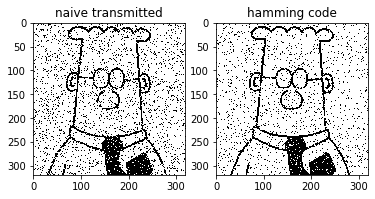

In [280]:
hc = HammingCode()
f = 0.10
received = transmit(hc.encode(ds), f=f)
s_hat = hc.decode(received)
naive = transmit(ds, f=f)
print(f'rc3 error probability: {error(ds, s_hat)}')
print(f'naive error probability: {error(ds, naive)}')
f, ax = plt.subplots(1, 2)
ax[0].set_title("naive transmitted")
ax[1].set_title("hamming code")
ax[0].imshow(naive.reshape(dilbert_bw.shape), cmap='gray')
ax[1].imshow(s_hat.reshape(dilbert_bw.shape), cmap='gray');


Question: can a particular choice of N and K actually increase the error probability?

In the (7, 4) case, the probability scales as $O(f^2)$, similarly to $\text{R}_3$ but the rate is $R=4/7$.

**Exercise 1.7** How many noise vectors give an all-zero syndrome?  
**Solution:** Basically what is the kernel of $\vec{H}$. Since its a $3\times7$ matrix and onto, the kernel is 4-dim. We are above mod-2 field so we get $2^4$ different noise vectors.

**Exercise 1.8** Show that two or more bit flips result in a block decoding error.  
**Solution:** Simply put, we always flip at most one bit when decoding. That means the if two or more bits were flipped, after decoding we will have at least one bit difference between the transmitted and received message. The possibility that only the parity bits will be corrupted can be discarded, since the decoder always outputs a valid (0-syndrome) message, and so the parity bits can't contradict the source bits, ie, if the parity bits are different, so is a bit in the source bits.

Some hard exercises to be done one day:
**Exercise 1.9/10/11**

_Shannon's noisy-channel coding theorem_ -
Information can be communicated over a noisy channel at a non-zero rate with arbitrarily small error probability.  
We will explore this result throughout the book.

## Probability, Entropy and Inference

The next section offers a review of the topics in the headline.


In [292]:
def h2(x):
    if x == 0 or x == 1:
        return 1*np.log2(1)
    return x*np.log2(1/x) + (1-x)*np.log2(1/(1-x))

h2(0.47)

0.9974015885677394

Some definitions...  
**Ensemble** $X$ is a triple $(x,\mathcal{A}_X,\mathcal{P}_X)$, $x\in\mathcal{A}_X$, $P(x=a_i)=p_i\in\mathcal{P}_X$  
**Joint ensemble** $XY$ ordered pairs of $X$ and $Y$.  
**Marginal probability** from $P(x,y)$ we can obtain $P(x)$ by summation
$$P(x=a_i)=\sum_{y\in\mathcal{A}_Y}P(x=a_i,y)$$
**Conditional probability** 
$$P(x\mid y)\equiv \frac{P(x,y)}{P(y)}\text{ if }P(y)\neq0$$

The marginal probabilities can be calculated from the joint probabilities, but not vice versa, except when both RVs are independent.

$\newcommand{hyp}{\mathcal{H}}$
**Product rule** $$P(x,y\mid\hyp)=P(x\mid y,\hyp)P(y\mid\hyp)=P(y\mid x,\hyp)P(x\mid\hyp)$$
**Sum rule** הסתברות שלמה
$$\begin{align}
P(x\mid\hyp) &= \sum_yP(x,y\mid\hyp) \\
&= \sum_yP(x\mid y,\hyp)P(y\mid\hyp) 
\end{align}$$
**Bayes' theorem** 
$$P(y\mid x,\hyp) = \frac{P(x\mid y,\hyp)P(y\mid\hyp)}{P(x\mid\hyp)}$$


**Example - Test and Disease**  
$a=1\text{ or } 0$ if Jo has the disease.  
$b=1\text{ or } 0$ if the test is positive.  
The test is 95% reliable, so $P(b=x\mid a=x)=0.95$. We also know that $P(a=1)=0.1$. So, what is $P(a=1\mid b=1)$? Now here's a thing to notice, which is evident in formulas but not in words. the reliability isn't the same thing as what is requested. I tried to think, if someone asks me why, what would I answer. I would say, the reliability of the test is not enough to know. The stupidest, and perhaps not strongest example is inventing a test for a nonexistent disease, which spits out no a negative example 95% of the time.

The solution is a straightforward application of Bayes' rule.

The book takes the Bayesian view of statistics, that we can represent belief in propositions numerically and use the laws of probabilities to calculate these beliefs and their effect by evidence. It can be shown that any belief system following a set of axioms called the _Cox Axioms_  can be represented using probability.

An example of a belief can be, "Trump will win the 2020-election". That is a controversial view (not trump, bayesian statistics) and on the other hand we have frequentists we believe probability can only be used on repeatable events such as coin tosses.


**Forward and inverse probabilities**
Haven't heard of this distinction before. The terse definition is you have a generative model, describing a process the will create some data. In a forward problem you would compute something about a quantity produced by the process, in an inverse problem you would compute conditional probability of some unobserved variable in the process, give the observed variables. For example, mean of 10 coin tosses vs inferring the bias of the coin (there is a better example in the book where both unknowns are purely random).

Let's take a computational look at example 2.6, the prediction part

0.3328491890583394

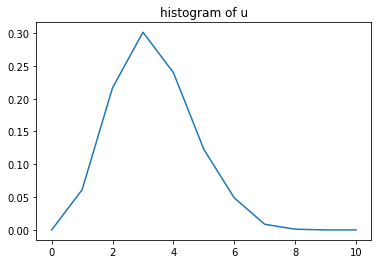

In [63]:
N = 10
S = 100000
u_arr = np.zeros(11)
Nplus1 = []
for i in range(S):
    u = np.random.randint(0, 11) # urn
    n_b = np.random.binomial(N, u/10.) # black is 1, white 0
    if n_b == 3:
        u_arr[u] += 1
        Nplus1.append(np.random.binomial(1, u/10.))

fig, ax, = plt.subplots()        
ax.plot(u_arr/sum(u_arr))
ax.set_title("histogram of u")

sum(Nplus1)/len(Nplus1)

So here's a brute force approach to approximate the probability. We simluate the described process. Why is it correct? at first I figured, let's sample u, pretend we got 3 blacks and sample another ball, and use that data to estimate the probability. But I had a hunch it's wrong. So I went all the way, and only calculated if we actually sampled 3 black balls. Kept all the results. Why is `sum(Nplus1)/len(Nplus1)` an approximation?
$$\frac{\#\left\{\text{ball}_{N+1}=\text{black}\wedge n_b=3\right\}}{\#\left\{n_b=3\right\}}$$
If we divide numerator and denominator by S we get an approximation of the unconditional probability
$$\frac{P(\text{ball}_{N+1}=\text{black}\wedge n_b=3)}{P(n_b=3)} = 
P(\text{ball}_{N+1}=\text{black}\mid n_b=3)$$     

But why was my original idea wrong? Following the formula above we would have gotten $\frac{\#\left\{\text{ball}_{N+1}=\text{black}\right\}}{S}\approx P(\text{ball}_{N+1}=\text{black})$, basically what is the probability that the next ball (or the first ball for that matter) will be black, without any assumptions on the urn. The knowledge that the among the N balls were 3 black balls "changes" the distribution of u, so it's no longer uniform. I acheived that approximately by simply ignoring times when $n_b!=3$, but we could have used the distribution calculated earlier in the book instead.
**BREAK!**


Let's rewrite Bayes' theorem in an inference form:
$$P(\theta\mid D,\hyp)=\frac{P(D\mid\theta,\hyp)P(\theta\mid\hyp)}{P(D\mid\hyp)}$$
and in words:
$$\text{posterior}=\frac{\text{likelihood}\times\text{prior}}{\text{evidence}}$$

**The likelihood prinicple:** given a generative model for data $d$ given parameters $\theta, P(d\mid\theta)$, and having observed a prticular outcome $d_1$, all inferences and predictions should depend only on the function $P(d_1\mid\theta)$. [nice article in wikipedia](https://en.wikipedia.org/wiki/Likelihood_principle).

I'm not entirely sure I got it, but crudely, the inference should depend on what happened, not what might have happened.

### Entropy
**Shannon information content of an outcome $x$**
$$h(x)=\log_2\frac1{P(x)}$$
measured in bits (and not by chance). We'll see that it's a natural measure of information content for an event.
**The entropy of an ensemble $X$** is the average Shannon information content of an outcome:
$$H(X)\equiv\sum_{x\in\mathcal{A}_X}P(x)\log\frac1{P(x)}$$

Some properties:
- $H(X)\geq0$ with equality iff $p_i=1$ for some i.
- Entropy is maximized if $\vec p$ is uniform: $$
H(X)\leq\log(\left|\mathcal{A}_X\right|)\:\text{with equality iff } p_i=1/\left|\mathcal{A}_X\right|\text{for all }i$$
- $H(X,Y)=H(X)+H(Y)\:\text{ iff }P(x,y)=P(x)P(y)$

_TODO: Prove these properties_

Entropy has a recursive property where if you can imagine the calculated probabilities as a process you could calculate the entropy as a linear combination of the entropies of the steps.

Finally, **The relative entropy _or_ Kullback-Leibler divergence** between $P(x)$ and $Q(x)$ defined over $\mathcal{A}_X$ is
$$D_\text{KL}(P\|Q)=\sum_xP(x)\log\frac{P(x)}{Q(x)}$$
and it satisfies _Gibbs' inequality_ $$D_\text{KL}(P\|Q)\geq0$$

Supposedly important further on!

The rest of the chapter is about convexity and _Jensen's inequality_. I'll save myself the trouble for now.

### Exercises
Ho, if I weren't lazy! I should pick a couple and solve 'em.

## More about Inference
TBD